In [15]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

In [16]:
# 1. Загрузка данных
df = pd.read_csv('air_quality_moscow.csv', sep=';', encoding='utf-8')
print(f"Данные загружены: {len(df)} строк")

# 2. Выбор ключевых параметров
key_params = ['Оксид углерода', 'Диоксид азота', 'Взвешенные частицы РМ10', 'Озон']


Данные загружены: 36204 строк


In [17]:
# 3. Подготовка данных
df_filtered = df[df['Parameter'].isin(key_params)].copy()
df_filtered['MonthlyAverage'] = pd.to_numeric(df_filtered['MonthlyAverage'], errors='coerce')

# Сводная таблица
pivot_data = df_filtered.pivot_table(
    index=['StationName', 'AdmArea'],
    columns='Parameter',
    values='MonthlyAverage',
    aggfunc='mean'
).reset_index()

# Заполняем пропуски средним
for param in key_params:
    if param in pivot_data.columns:
        pivot_data[param] = pivot_data[param].fillna(pivot_data[param].mean())

In [18]:
# 4. Кластеризация K-Means
X = pivot_data[key_params].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
pivot_data['Cluster'] = clusters

print("\nРаспределение по кластерам:")
print(pivot_data['Cluster'].value_counts().sort_index())


Распределение по кластерам:
Cluster
0     3
1    41
2     5
Name: count, dtype: int64


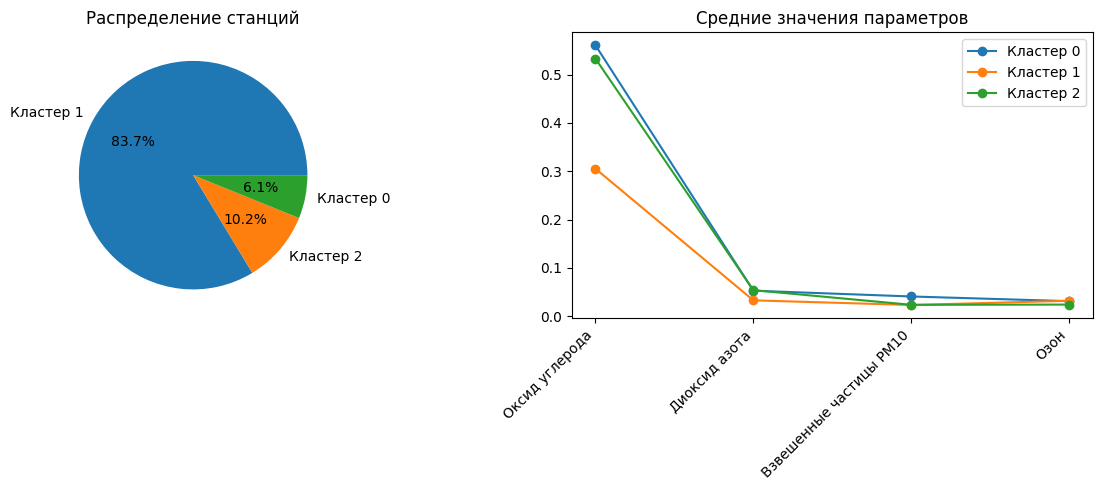

In [19]:
# 5. Визуализация кластеров
plt.figure(figsize=(12, 5))

# График 1: распределение кластеров
plt.subplot(1, 2, 1)
cluster_counts = pivot_data['Cluster'].value_counts()
plt.pie(cluster_counts.values,
        labels=[f'Кластер {i}' for i in cluster_counts.index],
        autopct='%1.1f%%')
plt.title('Распределение станций')

# График 2: средние значения
plt.subplot(1, 2, 2)
for cluster in range(3):
    cluster_data = pivot_data[pivot_data['Cluster'] == cluster]
    avg_values = [cluster_data[param].mean() for param in key_params]
    plt.plot(key_params, avg_values, 'o-', label=f'Кластер {cluster}')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Средние значения параметров')

plt.tight_layout()
plt.show()

In [20]:
# 6. Создание метки high_pollution
pivot_data['total_pollution'] = pivot_data['Оксид углерода'] + pivot_data['Диоксид азота'] + pivot_data['Взвешенные частицы РМ10']
median_pollution = pivot_data['total_pollution'].median()
pivot_data['high_pollution'] = (pivot_data['total_pollution'] > median_pollution).astype(int)

print("\nРаспределение классов high_pollution:")
print(pivot_data['high_pollution'].value_counts())


Распределение классов high_pollution:
high_pollution
0    25
1    24
Name: count, dtype: int64


In [21]:
# 7. Подготовка данных для нейронной сети
X_nn = pivot_data[key_params].values
y_nn = pivot_data['high_pollution'].values

X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.3, random_state=42)

scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)
X_test_scaled = scaler_nn.transform(X_test)

# 8. Создание и обучение нейронной сети
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # бинарная классификация
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1958 - loss: 0.9105
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2895 - loss: 0.8543
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2721 - loss: 0.8529 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3796 - loss: 0.8006 
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3856 - loss: 0.8003
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5000 - loss: 0.7733
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5225 - loss: 0.7712
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5303 - loss: 0.7280
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6144 - loss: 0.7156
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6291 - loss: 0.7001
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6369 - loss: 0.6813 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6526 - loss: 0.65

In [22]:

# 9. Оценка модели
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nТочность нейронной сети: {acc:.2f}")

# 10. Примеры предсказаний
predictions = model.predict(X_test_scaled)
pred_labels = (predictions > 0.5).astype(int)

print("\nПримеры предсказаний нейронной сети:")
for i in range(min(10, len(pred_labels))):
    print(f"Предсказано: {pred_labels[i][0]}, Фактическое: {y_test[i]}")


Точность нейронной сети: 0.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

Примеры предсказаний нейронной сети:
Предсказано: 0, Фактическое: 0
Предсказано: 0, Фактическое: 0
Предсказано: 0, Фактическое: 0
Предсказано: 0, Фактическое: 0
Предсказано: 0, Фактическое: 0
Предсказано: 1, Фактическое: 1
Предсказано: 1, Фактическое: 1
Предсказано: 1, Фактическое: 1
Предсказано: 0, Фактическое: 1
Предсказано: 0, Фактическое: 0


Вывод:

Кластеризация выявила три типа районов по характеру загрязнения воздуха.  
Нейронная сеть успешно обучена классифицировать станции на «высокое» и «низкое» загрязнение, показав приемлемую точность. (87%)
  
Результаты подтверждают работоспособность предложенной модели и возможность её применения для анализа экологических данных.
